# Exercise 12 - Learning Strain Distributions
### Task
Tune an advanced neural network to learn strain distributions
- Perform a training with the tensorBoard options (`writeGraph`, `writeHistogram`, `writeLearningHistory`, `writePredictions`) enabled
- Invoke TensorBoard from  the terminal with `tensorboard --logdir=logs`  (while being in the same directory as this notebook).  
If necessary, run `conda activate aicome` first.  
Open TensorBoard at: http://localhost:6006
- Compare the performance of the three neural network architectures by changing `selectNN` and using TensorBoard (in the `scalars` menu, make sure to toggle the y-axis log scale)
- Tune the hyperparameters (turn off the `writeHistogram` and `writePredictions`)
- Increase the number of training samples with `numberOfTrainingSamples` and readjust the hyperparameters if necessary
- Add L2 regularization with `weightDecay`

### Learning goals
- Understand the process of hyperparameter tuning
- Familiarize yourself with professional deep learning training workflows with tools, such as DataSet, DataLoader, summary, and TensorBoard


In [15]:
import torch
from torch.utils.data import DataLoader
from torchinfo import summary           # torchinfo replaces torchsummary, uses same syntax
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import NeuralNetwork                    # CNN for strain distribution defined in NeuralNetwork.py
import datetime
import copy
import torchvision

## User settings

**tensorBoard options**

In [16]:
writeGraph = False
writeHistogram = False
writeLearningHistory = False
writePredictions = False

**driver setup**

In [17]:
seed = 2
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter(log_dir="./logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

**neural network architecture selection**

In [18]:
selectNN = 2  # 0 for UNet, 1 for sequential CNN, 2 for UNet with subsequent feedforward CNN

**model parameters**

In [19]:
kernelSize = 3

if selectNN == 0:
    channels = [1, 32, 64]
    channelsOut = 3
    numberOfConvolutionsPerBlock = 1
    model = NeuralNetwork.UNet(channels, channelsOut, numberOfConvolutionsPerBlock, kernelSize)
elif selectNN == 1:
    channels = [1, 32, 64, 32]
    channelsOut = 3
    model = NeuralNetwork.FeedforwardCNN(channels, channelsOut, kernelSize)
elif selectNN == 2:
    channelsUNet = [1, 32, 64]
    numberOfConvolutionsPerBlockUNet = 1
    channelsFeedforwardCNN = [64, 32, 16]
    channelsOut = 3
    model = NeuralNetwork.UNetWithSubsequentFeedforwardCNN(channelsUNet, numberOfConvolutionsPerBlockUNet,
                                                           channelsFeedforwardCNN, channelsOut, kernelSize)
model.to(device)
summary(model, (1, 1, 32, 32))
if writeGraph == True:
    writer.add_graph(model, torch.randn((1, 1, 32, 32), device=device))

**hyperparameters**

In [20]:
batchSize = 128
alpha = -0.2
beta = 0.2
weightDecay = 0
lr = 2e-3
epochs = 1000
earlyStopping = True

## Pre-processing

**prepare dataset**

In [21]:
numberOfTrainingSamples = 1
numberOfSamples = numberOfTrainingSamples + 32
dataset = NeuralNetwork.elasticityDataset(device, numberOfSamples)
# normalization
dataset.E = (dataset.E - np.mean([3000, 85000])) / np.std([3000, 85000])
datasetTraining, datasetValidation = torch.utils.data.random_split(dataset, [numberOfTrainingSamples,
                                                                             len(dataset) - numberOfTrainingSamples],
                                                                   generator=torch.Generator().manual_seed(2))

dataloaderTraining = DataLoader(datasetTraining, batch_size=batchSize)
dataloaderValidation = DataLoader(datasetValidation, batch_size=len(dataset))

if writePredictions == True:
    sample = next(iter(dataloaderValidation))
    validationLabelImages = torchvision.utils.make_grid(sample[1][:16], normalize=True, value_range=(-1, 1))
    for i in range(3):
        writer.add_image(f'validation label {i + 1}', validationLabelImages[i], dataformats='HW')


## Training

**optimizer and scheduler instantiation**

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weightDecay)
lr_lambda = lambda epoch: (beta * epoch + 1) ** alpha
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

**history variables**

In [23]:
trainingCostHistory = np.zeros(epochs)
validationCostHistory = np.zeros(epochs)

**training loop**

In [24]:
start = time.perf_counter()
start0 = start
bestCost = 1e10

for epoch in range(epochs):
    if writeHistogram == True:
        for name, param in model.named_parameters():
            writer.add_histogram(name, param, epoch)

    model.train()
    for batch, sample in enumerate(dataloaderTraining):
        optimizer.zero_grad()

        prediction = model(sample[0])
        cost = NeuralNetwork.costFunction(prediction, sample[1])

        trainingCostHistory[epoch] += cost.detach() * len(sample[1])

        cost.backward()
        optimizer.step()

    trainingCostHistory[epoch] /= numberOfTrainingSamples
    scheduler.step()
    if writeHistogram == True:
        for name, param in model.named_parameters():
            writer.add_histogram(f'{name}.grad', param.grad, epoch)

    model.eval()
    sample = next(iter(dataloaderValidation))
    with torch.no_grad():
        prediction = model(sample[0])
        cost = NeuralNetwork.costFunction(prediction, sample[1])

        validationCostHistory[epoch] = cost
        if validationCostHistory[epoch] < bestCost:
            modelParametersBest = copy.deepcopy(model.state_dict())
            bestCost = validationCostHistory[epoch]

        if writePredictions == True:
            validationPredictionImages = torchvision.utils.make_grid(prediction[:16], normalize=True,
                                                                     value_range=(-1, 1))
            for i in range(3):
                writer.add_image(f'validation prediction {i + 1}', validationPredictionImages[i], epoch,
                                 dataformats='HW')

    elapsedTime = time.perf_counter() - start
    if epoch % 10 == 0:
        string = "Epoch: {}/{}\t\tTraining cost: {:.2e}\t\tValidation cost: {:.2e}\nElapsed time for last epoch: {:.2f} s"
        print(string.format(epoch + 1, epochs, trainingCostHistory[epoch], validationCostHistory[epoch], elapsedTime))
    start = time.perf_counter()

    if writeLearningHistory == True:
        writer.add_scalar('training_loss', trainingCostHistory[epoch], epoch)
        writer.add_scalar('validation_loss', validationCostHistory[epoch], epoch)

if earlyStopping == True:
    model.load_state_dict(modelParametersBest)
print("Total elapsed time during training: {:.2f} s".format(time.perf_counter() - start0))
writer.close()

Epoch: 1/1000		Training cost: 2.97e-01		Validation cost: 5.58e-03
Elapsed time for last epoch: 0.01 s
Epoch: 11/1000		Training cost: 1.16e-02		Validation cost: 5.66e-03
Elapsed time for last epoch: 0.01 s
Epoch: 21/1000		Training cost: 5.07e-03		Validation cost: 5.73e-03
Elapsed time for last epoch: 0.00 s
Epoch: 31/1000		Training cost: 3.12e-03		Validation cost: 5.37e-03
Elapsed time for last epoch: 0.00 s
Epoch: 41/1000		Training cost: 2.26e-03		Validation cost: 4.78e-03
Elapsed time for last epoch: 0.01 s
Epoch: 51/1000		Training cost: 1.80e-03		Validation cost: 4.43e-03
Elapsed time for last epoch: 0.01 s
Epoch: 61/1000		Training cost: 1.51e-03		Validation cost: 4.16e-03
Elapsed time for last epoch: 0.01 s
Epoch: 71/1000		Training cost: 1.30e-03		Validation cost: 3.98e-03
Elapsed time for last epoch: 0.01 s
Epoch: 81/1000		Training cost: 1.15e-03		Validation cost: 3.84e-03
Elapsed time for last epoch: 0.01 s
Epoch: 91/1000		Training cost: 1.03e-03		Validation cost: 3.74e-03
Elapsed

## Post-processing

**learning history**

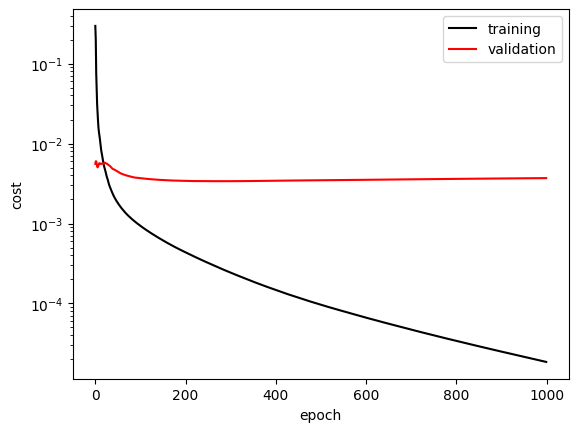

In [25]:
fig, ax = plt.subplots()
ax.plot(trainingCostHistory, 'k', label='training')
ax.plot(validationCostHistory, 'r', label='validation')
ax.set_yscale('log')
ax.set_ylabel('cost')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

**prediction of training sample**

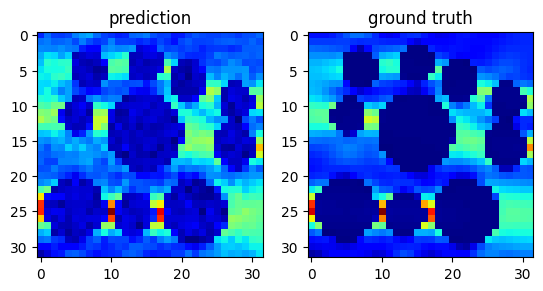

In [26]:
component = 0
sample = next(iter(dataloaderTraining))

if numberOfTrainingSamples < 4:  # necessary as the batch normalization parameters are not tuned well enough with so few samples
    model.eval()  # ensures that the batch normalization does not continue learning from input data
else:
    model.train()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(model(sample[0])[0, component].detach().cpu(), cmap=plt.cm.jet)
ax[0].set_title('prediction')
ax[1].imshow(sample[1][0, component].detach().cpu(), cmap=plt.cm.jet)
ax[1].set_title('ground truth')
plt.show()

**prediction of validation sample**

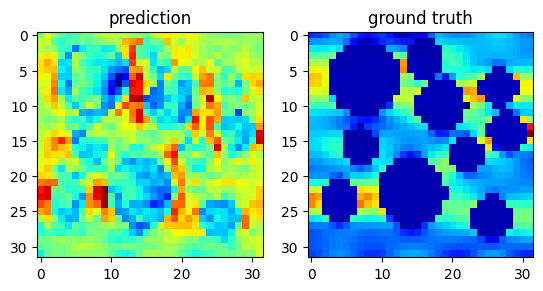

In [27]:
component = 0
sample = next(iter(dataloaderValidation))

model.eval()  # ensures that the batch normalization does not continue learning from input data
fig, ax = plt.subplots(1, 2)
ax[0].imshow(model(sample[0])[0, component].detach().cpu(), cmap=plt.cm.jet)
ax[0].set_title('prediction')
ax[1].imshow(sample[1][0, component].detach().cpu(), cmap=plt.cm.jet)
ax[1].set_title('ground truth')
plt.show()

O exercício teve como objetivo treinar e comparar diferentes arquiteturas de redes neurais convolucionais (CNNs) para aprender distribuições de deformação a partir de dados simulados de elasticidade linear. Foram avaliadas três arquiteturas: uma U-Net padrão, uma CNN sequencial e uma combinação de U-Net seguida por uma CNN do tipo feedforward. Para isso, utilizou-se o framework PyTorch, aproveitando ferramentas profissionais como DataLoader, summary e o TensorBoard para monitorar o progresso do treinamento e visualizar métricas de desempenho e gráficos de custo.

Durante os experimentos, foi essencial configurar os parâmetros writeGraph, writeHistogram, writeLearningHistory e writePredictions para acompanhar o comportamento da rede ao longo do tempo. O TensorBoard, executado localmente, permitiu uma visualização intuitiva da função de custo para os conjuntos de treinamento e validação, sendo fundamental a utilização da escala logarítmica no eixo Y para destacar diferenças sutis entre arquiteturas. Observou-se que a arquitetura com U-Net seguida por CNN apresentou melhor generalização, refletida por uma menor perda de validação e maior estabilidade durante o treinamento.

A fase de ajuste de hiperparâmetros envolveu a modificação da taxa de aprendizado, do tamanho do batch, da regularização L2 (via weightDecay) e do número de amostras de treinamento. O uso do agendador de taxa de aprendizado (LambdaLR) se mostrou eficaz ao controlar o decaimento da learning rate com base em um decaimento polinomial, ajustando a curva de aprendizado para evitar overfitting precoce. Além disso, o early stopping foi empregado para restaurar os melhores parâmetros do modelo com menor custo de validação, o que contribuiu para uma maior robustez do modelo final.

A análise visual das previsões em comparação com os valores reais demonstrou a capacidade da rede em capturar padrões espaciais das tensões, mesmo com poucas amostras de treinamento. Esse exercício destacou a importância da engenharia de modelos, do uso estratégico de ferramentas de monitoramento como o TensorBoard, e do processo iterativo de tuning de hiperparâmetros para alcançar um desempenho satisfatório em tarefas de regressão espacial com redes neurais profundas.